In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [60]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
# experiment_sub_dir = "2025Jul09-171538_configs" # good latest run

experiment_sub_dir = "2025Aug06-110724_configs" 

exp_path = os.path.join(os.path.abspath("."), "results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.model', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

In [61]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.model,sub_experiment_path,seed,experiment_name
0,training,200000,0.983159,-8.688995,-1.706744,-4.734551,-4.710948,0.950079,-8.030124,-1.667804,...,1.301374,1.358575,0.785215,48749.0,192.0,0 days 00:08:49.491887,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
1,training,400000,0.965886,-7.634091,-1.718863,-4.587024,-4.567281,0.872402,-7.126526,-1.672921,...,-0.483601,-0.214338,0.858335,50000.0,200.0,0 days 00:10:14.970320,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
2,training,600000,0.948614,-7.402028,-1.347262,-4.380902,-4.349656,0.809208,-6.931097,-1.322677,...,-0.907227,-0.582918,1.137991,50000.0,200.0,0 days 00:10:36.351732,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
3,training,800000,0.931341,-7.065732,-1.593040,-4.231728,-4.223611,0.757683,-6.640128,-1.556891,...,-0.960240,-0.635317,1.189244,50000.0,200.0,0 days 00:10:43.679740,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
4,training,1000000,0.914068,-6.910412,-1.457210,-4.084122,-4.076359,0.750837,-6.501790,-1.423087,...,-0.965425,-0.644986,1.182389,50000.0,200.0,0 days 00:10:43.834874,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,validation,11200000,NaN,-6.612443,-3.978120,-5.108549,-4.711764,1.119720,-6.278464,-3.803148,...,-1.343925,-0.895088,1.591247,NaN,NaN,0 days 00:00:02.368200,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
716,validation,11400000,NaN,-6.619435,-3.986238,-5.129082,-4.714373,1.109759,-6.284541,-3.810448,...,-1.324202,-0.852175,1.611971,NaN,NaN,0 days 00:00:02.442186,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
717,validation,11600000,NaN,-6.619437,-3.987122,-5.077948,-4.717974,1.099521,-6.284499,-3.811280,...,-1.342266,-0.908845,1.584468,NaN,NaN,0 days 00:00:02.486021,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
718,validation,11800000,NaN,-6.617680,-3.986495,-5.115499,-4.719006,1.118415,-6.282714,-3.810446,...,-1.344238,-0.888327,1.587537,NaN,NaN,0 days 00:00:02.378607,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC


In [62]:
df[df['epoch_type'] == 'validation']
# df[df['epoch_type'] == 'training']


,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.model,sub_experiment_path,seed,experiment_name
60,validation,200000,NaN,-8.211329,-5.132920,-6.533161,-6.255303,1.271944,-7.653040,-4.819956,...,0.040431,0.179660,0.478571,NaN,NaN,0 days 00:00:01.557655,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
61,validation,400000,NaN,-7.797833,-4.746884,-6.133499,-5.855803,1.260892,-7.309781,-4.487798,...,-0.981594,-0.606739,1.259298,NaN,NaN,0 days 00:00:01.741862,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
62,validation,600000,NaN,-7.599953,-4.696318,-6.012802,-5.742165,1.200706,-7.133241,-4.441790,...,-1.279585,-0.822248,1.514437,NaN,NaN,0 days 00:00:01.757389,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
63,validation,800000,NaN,-7.314923,-4.490320,-5.735256,-5.400547,1.177138,-6.887362,-4.260988,...,-1.343542,-0.866220,1.565332,NaN,NaN,0 days 00:00:02.525227,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
64,validation,1000000,NaN,-7.306711,-4.468007,-5.701999,-5.438301,1.167075,-6.880099,-4.240304,...,-1.338049,-0.890403,1.564973,NaN,NaN,0 days 00:00:02.388831,OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.model_OpinionNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,validation,11200000,NaN,-6.612443,-3.978120,-5.108549,-4.711764,1.119720,-6.278464,-3.803148,...,-1.343925,-0.895088,1.591247,NaN,NaN,0 days 00:00:02.368200,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
716,validation,11400000,NaN,-6.619435,-3.986238,-5.129082,-4.714373,1.109759,-6.284541,-3.810448,...,-1.324202,-0.852175,1.611971,NaN,NaN,0 days 00:00:02.442186,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
717,validation,11600000,NaN,-6.619437,-3.987122,-5.077948,-4.717974,1.099521,-6.284499,-3.811280,...,-1.342266,-0.908845,1.584468,NaN,NaN,0 days 00:00:02.486021,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC
718,validation,11800000,NaN,-6.617680,-3.986495,-5.115499,-4.719006,1.118415,-6.282714,-3.810446,...,-1.344238,-0.888327,1.587537,NaN,NaN,0 days 00:00:02.378607,OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0001_agent_params.model_OpinionNetIndependentABC


In [63]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.model    OpinionNet
Name: 0, dtype: object
Best mean reward: -4.447211739419166


In [64]:
averaged_results

,sub_exp_cfg_agent_params.model,episode_rewards_mean,sub_experiment_path
0,OpinionNet,-4.447212,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,OpinionNetIndependentABC,-4.447212,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [65]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

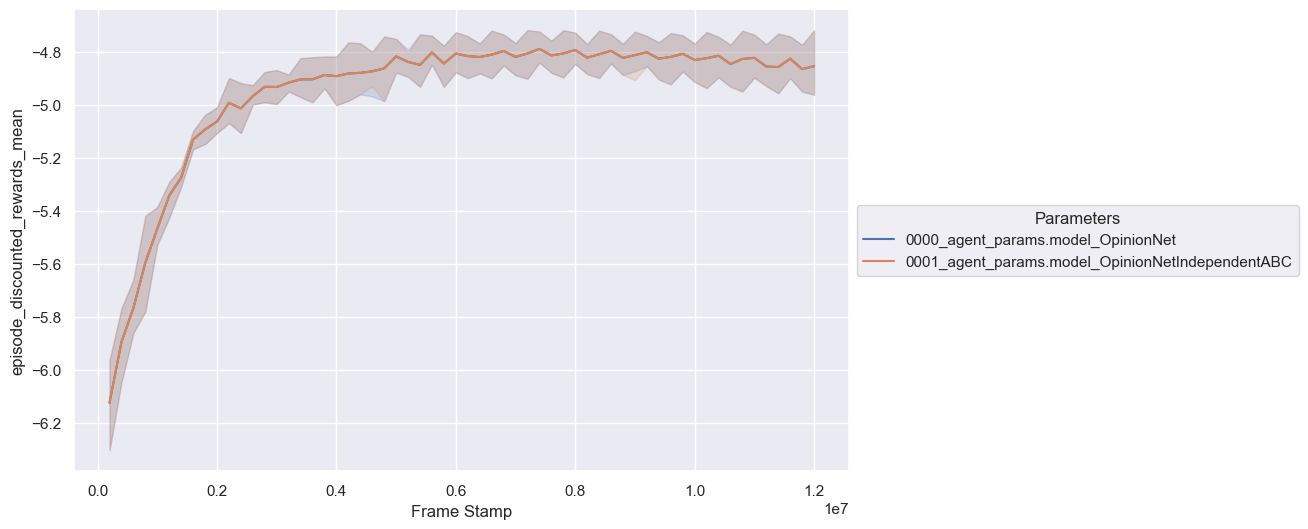

In [66]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']
# validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [67]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.model', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

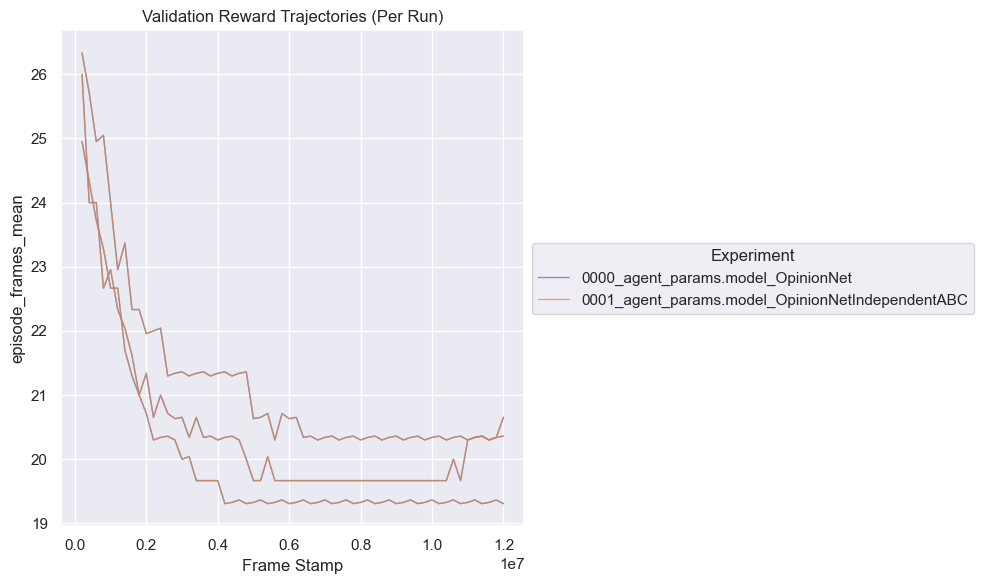

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [69]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.model
119,validation,12000000,-4.941335,19.307692,-4.719692,NaN,NaN,0 days 00:00:02.491141,0,0000_agent_params.model_OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet
239,validation,12000000,-5.214142,20.653061,-4.962821,NaN,NaN,0 days 00:00:02.163225,1,0000_agent_params.model_OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet
359,validation,12000000,-5.126376,20.360000,-4.882620,NaN,NaN,0 days 00:00:02.285610,2,0000_agent_params.model_OpinionNet,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNet
479,validation,12000000,-4.941335,19.307692,-4.719692,NaN,NaN,0 days 00:00:02.042449,0,0001_agent_params.model_OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetIndependentABC
599,validation,12000000,-5.214142,20.653061,-4.962821,NaN,NaN,0 days 00:00:02.111847,1,0001_agent_params.model_OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetIndependentABC
719,validation,12000000,-5.126376,20.360000,-4.882620,NaN,NaN,0 days 00:00:02.039538,2,0001_agent_params.model_OpinionNetIndependentABC,d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,OpinionNetIndependentABC


In [70]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_agent_params.model,episode_discounted_rewards_mean
0,OpinionNet,-4.855044
1,OpinionNetIndependentABC,-4.855044


In [71]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_agent_params.model'],
      dtype='object')

In [72]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])



d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Aug06-110724_configs\0000_agent_params.model_OpinionNet\0


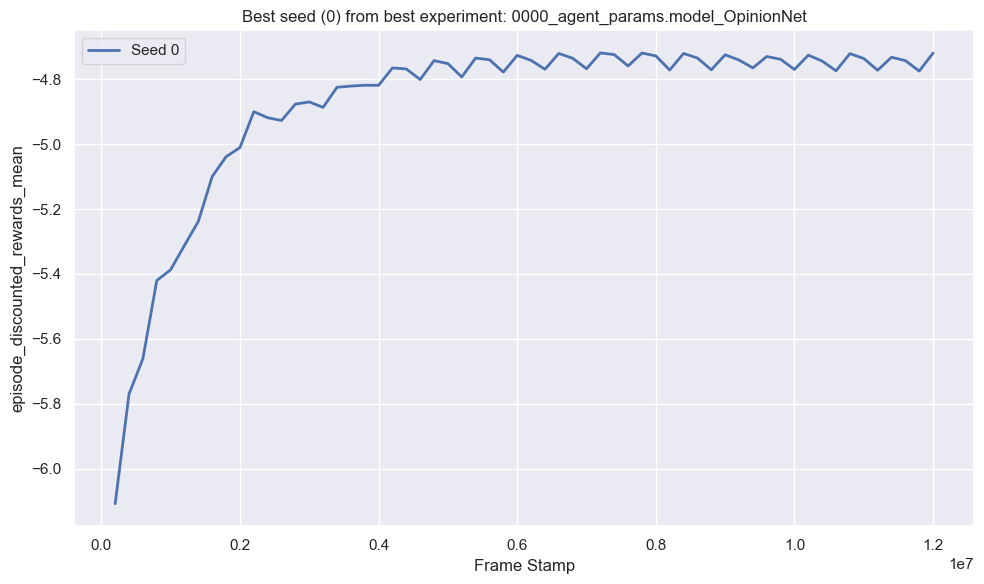

In [73]:
selected_metric = 'episode_discounted_rewards_mean'
hue_col = "experiment_name"

# Filter for training data only
# training_df = df[df['epoch_type'] == 'training']
training_df = df[df['epoch_type'] == 'validation']

# Step 1: Find best experiment
experiment_means = training_df.groupby(hue_col)[selected_metric].mean()
best_experiment = experiment_means.idxmax()

# Step 2: Filter to that experiment
best_exp_df = training_df[training_df[hue_col] == best_experiment]

# Step 3: Find best seed within best experiment
best_seed = (
    best_exp_df.groupby('seed')[selected_metric]
    .mean()
    .idxmax()
)

# Step 4: Filter to best seed
best_seed_df = best_exp_df[best_exp_df['seed'] == best_seed]

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)

plt.title(f"Best seed ({best_seed}) from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

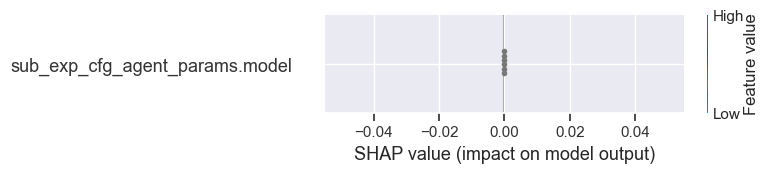

In [74]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [75]:
hyperparam_columns

['sub_exp_cfg_agent_params.model']

In [76]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()


IndexError: list index out of range